# Feature selection (LASSO)
## Timo Vijn

# Load necessary packages

In [1]:
import pandas as pd
import numpy as np

hex_salmon = '#F68F83'
hex_gold = '#BC9661'
hex_indigo = '#2D2E5F'
hex_maroon = '#8C4750'
hex_white = '#FAFAFA'
hex_blue = '#7EB5D2'

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import matplotlib.dates as dates

import matplotlib.font_manager as font_manager
mpl.font_manager._rebuild()

mpl.rcParams['font.family'] = 'SF Mono'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.titleweight'] = 'semibold'
mpl.rcParams['axes.labelweight'] = 'medium'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
mpl.rcParams["figure.titlesize"] = 'large'
mpl.rcParams["figure.titleweight"] = 'semibold'

from termcolor import colored

from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso, LogisticRegression, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from entsoe import EntsoePandasClient

# Create features

In [2]:
features = pd.read_pickle(f"./features.pkl")

In [3]:
# import import_ipynb
# from data import create_features

# years = [2018]

# lags_ID = range(-4, -169, -1)
# lags_DA = [i for i in range(5, -6, -1) if i not in [0]]
# lags_VOL = [i for i in range(-4, -25, -1) if i not in [0]]

# ID, DA, features = create_features(years, lags_ID, lags_DA, lags_VOL)

In [4]:
# ID.head(5)

In [5]:
# DA.head(5)

In [6]:
features.head(5)

,ID3,VOL,MCP,LOAD,LOAD_F,LOAD_FE,ID3 (-4),ID3 (-5),ID3 (-6),ID3 (-7),...,HOD 14,HOD 15,HOD 16,HOD 17,HOD 18,HOD 19,HOD 20,HOD 21,HOD 22,HOD 23
2015-01-08 01:00:00+00:00,22.953776,439.5,32.32,9008.00,8505.25,502.75,29.934792,61.666667,61.118812,61.370370,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 02:00:00+00:00,23.168355,261.5,31.10,8889.25,8222.25,667.00,29.853669,29.934792,61.666667,61.118812,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 03:00:00+00:00,21.000000,420.5,30.17,8929.25,8122.25,807.00,24.012378,29.853669,29.934792,61.666667,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 04:00:00+00:00,30.000000,460.6,24.54,9423.75,8323.50,1100.25,23.269810,24.012378,29.853669,29.934792,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 05:00:00+00:00,30.000000,250.0,32.00,10884.50,9015.00,1869.50,22.953776,23.269810,24.012378,29.853669,...,0,0,0,0,0,0,0,0,0,0


# Separate train and test sets

In [7]:
X = features.drop(labels=['ID3', 'VOL', 'LOAD_F', 'LOAD_FE'], axis=1)
y = features['ID3']

# X = X.iloc[X.index.hour == h]
# y = y.iloc[y.index.hour == h]

# X = X.iloc[X.index.day == 13]
# y = y.iloc[y.index.day == 13]

# X = X.iloc[X.index.month == 8]
# y = y.iloc[y.index.month == 8]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.3,
    random_state = 0,
    shuffle = False)

X_train.shape, X_test.shape

((23691, 233), (10154, 233))

In [8]:
X_train.head(5)

,MCP,LOAD,ID3 (-4),ID3 (-5),ID3 (-6),ID3 (-7),ID3 (-8),ID3 (-9),ID3 (-10),ID3 (-11),...,HOD 14,HOD 15,HOD 16,HOD 17,HOD 18,HOD 19,HOD 20,HOD 21,HOD 22,HOD 23
2015-01-08 01:00:00+00:00,32.32,9008.00,29.934792,61.666667,61.118812,61.370370,47.332061,45.606383,49.019423,52.273953,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 02:00:00+00:00,31.10,8889.25,29.853669,29.934792,61.666667,61.118812,61.370370,47.332061,45.606383,49.019423,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 03:00:00+00:00,30.17,8929.25,24.012378,29.853669,29.934792,61.666667,61.118812,61.370370,47.332061,45.606383,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 04:00:00+00:00,24.54,9423.75,23.269810,24.012378,29.853669,29.934792,61.666667,61.118812,61.370370,47.332061,...,0,0,0,0,0,0,0,0,0,0
2015-01-08 05:00:00+00:00,32.00,10884.50,22.953776,23.269810,24.012378,29.853669,29.934792,61.666667,61.118812,61.370370,...,0,0,0,0,0,0,0,0,0,0


# Scale features

In [9]:
X_train_unscaled = X_train

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train_unscaled)

# Perform LASSO feature selection

## Determine optimal alpha

In [10]:
# n_folds = 5

# reg = LassoCV(alphas = np.logspace(-5, 0.5, 50), random_state = 10, cv = n_folds)
# reg.fit(X_train, y_train)

# coefficients = reg.coef_
# alpha = reg.alpha_

# print(), print(f'Optimal alpha: {alpha} ({round(alpha, 4)})'), print();

In [11]:
# # Display results
# EPSILON = 1e-4
# model = reg

# fig, ax = plt.subplots(figsize = (10, 5))

# # ax.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
# ax.plot(model.alphas_ + EPSILON, model.mse_path_, ':')

# ax.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
#          label = f'Average across all folds', linewidth=2)

# ax.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
#             label = rf'$\alpha$: {round(alpha, 4)}')

# ax.set_ylim(60, 150)
# ax.set_xlim(-1, 4)

# plt.legend()

# plt.xlabel(r'$\alpha$')
# plt.ylabel('MSE')
# plt.title(f'Mean square error on {n_folds} folds: coordinate descent');

## (Optional) Determine optimal alpha (2)

In [12]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV

n_folds = 10

# Define model

model = Lasso()
model_type = f'{model}'

# Define model evaluation method
cv = RepeatedKFold(
    n_splits = n_folds,
    n_repeats = 1,
    random_state = 10)

# Define grid
grid = dict()
grid['alpha'] = np.logspace(-3, 1, 50)
# grid['alpha'] = np.linspace(0, 2, 50)

# Define search
search = GridSearchCV(
    model,
    grid,
    scoring = 'neg_mean_squared_error',
    cv = cv,
    n_jobs = -1,
    verbose = 10)

# Perform the search
results = search.fit(X_train, y_train)

# Coefficients
coefficients = search.best_estimator_.coef_

# Alpha
alpha = results.best_params_['alpha']

# Summarize
print('MSE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.2s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  

## Visualise cross validation and optimal alpha

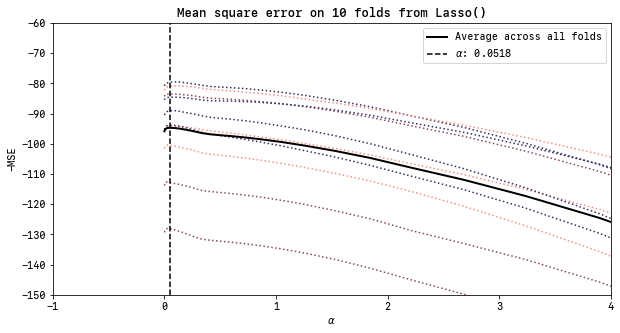

In [13]:
paths = pd.DataFrame()

fig, ax = plt.subplots(figsize = (10, 5))

for s in range(0, results.n_splits_):
    paths[f'Split {s}'] = results.cv_results_[f'split{s}_test_score']

x = results.param_grid['alpha']
y = paths

ax.plot(x, y, ':')

ax.plot(x, y.mean(axis = 1), 'k', label = f'Average across all folds', linewidth = 2)

ax.axvline(alpha, linestyle='--', color='k', label = rf'$\alpha$: {round(alpha, 4)}')

plt.legend()

plt.xlim([-10,2])
plt.ylim([-120,-80])

plt.xlim([-1,4])
plt.ylim([-150,-60])

plt.xlabel(r'$\alpha$')
plt.ylabel('-MSE')
plt.title(f'Mean square error on {n_folds} folds from {model_type}');

## Plot coefficients

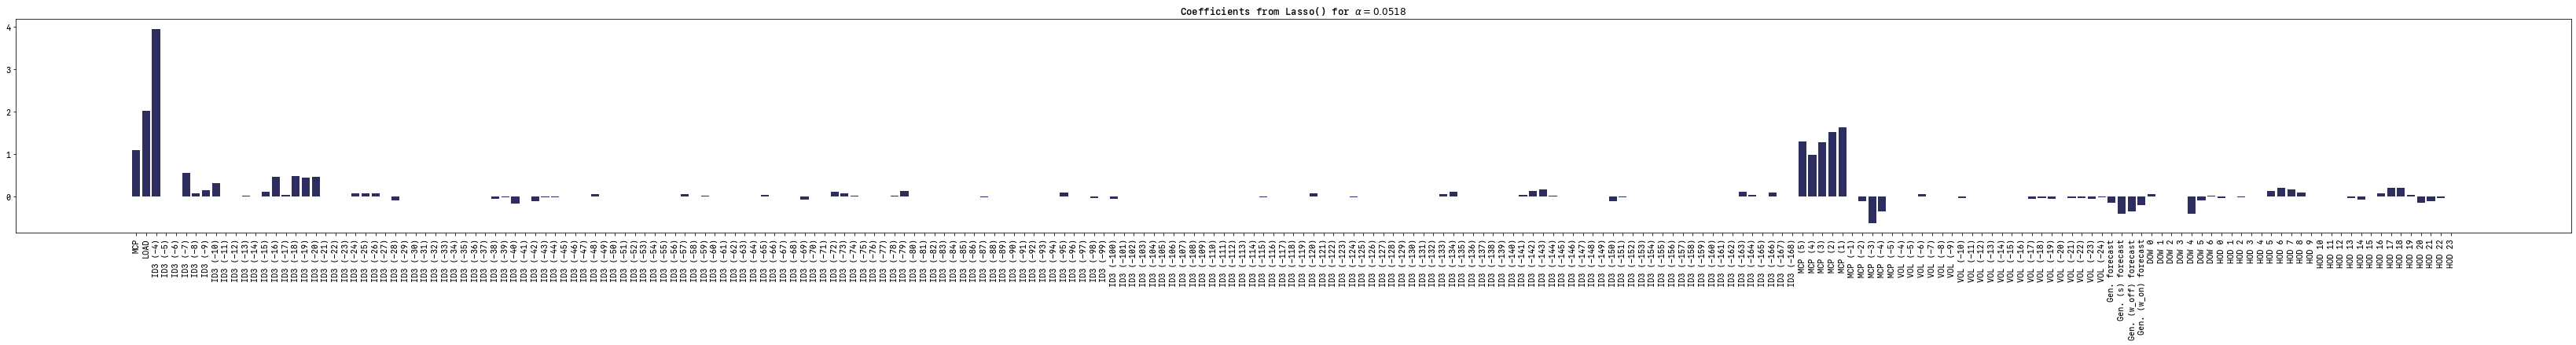

In [14]:
COEFS = pd.DataFrame()

COEFS['Coefficients'] = coefficients

COEFS.index = X_train_unscaled.columns.values

x = COEFS.index
y = COEFS['Coefficients']

fig, ax = plt.subplots(figsize = (len(x)/4, 5))
q = ax.bar(height = y, x = x)

plt.xticks(rotation = 90)
ax.set_title(rf'Coefficients from {model_type} for $\alpha = {round(alpha, 4)}$');

## Determine chosen features

In [15]:
# from sklearn.feature_selection import SelectFromModel
# from time import time

# n_features = 10

# threshold = np.sort(abs(coefficients))[-n_features]

# print(), print(f'Threshold: {threshold}'), print()

# tic = time()
# sel_ = SelectFromModel(model_fit, threshold = threshold)
# sel_.fit(X_train, y_train)

# toc = time()
# print(), print(f'Features selected by SelectFromModel: {COEFS.index[sel_.get_support()]}'), print()
# print(), print(f"Done in {toc - tic:.3f}s"), print();

# # LASSO

# # Features selected by SelectFromModel: Index(['MCP', 'Load', 'ID3 (-4)', 'ID3 (-18)', 'ID3 (-24)', 'MCP (-1)',
# #        'MCP (-2)', 'MCP (-3)', 'MCP (-4)', 'Gen. (w_off) forecast'],
# #       dtype='object')

# # Ridge

# # Features selected by SelectFromModel: Index(['MCP', 'Load', 'ID3 (-4)', 'ID3 (-5)', 'ID3 (-24)', 'MCP (-1)',
# #        'MCP (-2)', 'MCP (-3)', 'MCP (-4)', 'Gen. (w_off) forecast'],
# #       dtype='object')

# # ElasticNet

# # Features selected by SelectFromModel: Index(['MCP', 'Load', 'ID3 (-4)', 'ID3 (-18)', 'ID3 (-24)', 'MCP (-1)',
# #        'MCP (-2)', 'MCP (-3)', 'MCP (-4)', 'Gen. (w_off) forecast'],
# #       dtype='object')

In [16]:
from sklearn.feature_selection import SelectFromModel
from time import time

selected_coefficients = list()

n_features = 10

threshold = np.sort(abs(COEFS['Coefficients']))[-n_features]

print(), print(f'Threshold: {threshold}'), print()

sel_ = SelectFromModel(results.best_estimator_, threshold = threshold, prefit = True)

for i in sel_.get_support(indices = True):
    selected_coefficients.append(COEFS.index[i])


Threshold: 0.5538618709792422



In [17]:
sel_

SelectFromModel(estimator=Lasso(alpha=0.0517947467923121), prefit=True,
                threshold=0.5538618709792422)

In [18]:
print(), print(colored('Summary:', 'blue')), print()

print(f'Total features: {X_train_unscaled.shape[1]}')
print(f'Selected features: {len(X_train_unscaled.columns[(sel_.get_support())])}')
print(f'Features with coefficients shrank to zero: {np.count_nonzero(COEFS != 0)}')

print(), print(colored('Selected columns:', 'blue')), print()
print(X_train_unscaled.columns[sel_.get_support()])


Summary:

Total features: 233
Selected features: 10
Features with coefficients shrank to zero: 103

Selected columns:

Index(['MCP', 'LOAD', 'ID3 (-4)', 'ID3 (-7)', 'MCP (5)', 'MCP (4)', 'MCP (3)',
       'MCP (2)', 'MCP (1)', 'MCP (-3)'],
      dtype='object')


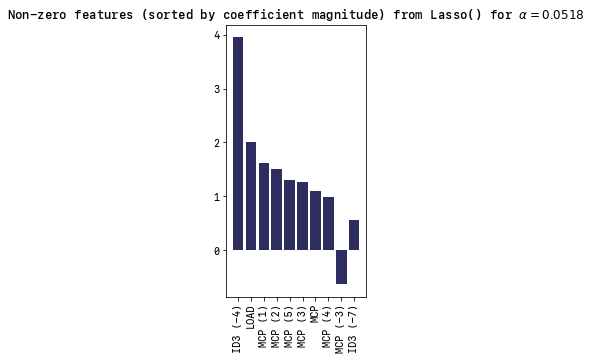

In [19]:
COEFS_sel = COEFS[sel_.get_support()].reindex(COEFS[sel_.get_support()]['Coefficients'].abs().sort_values(ascending = False).index)

x = COEFS_sel.index
y = COEFS_sel['Coefficients']

fig, ax = plt.subplots(figsize = (len(x)/4, 5))
q = ax.bar(height = y, x = x, width = 0.8)

plt.xticks(rotation = 90)
ax.set_title(rf'Non-zero features (sorted by coefficient magnitude) from {model_type} for $\alpha = {round(alpha, 4)}$');

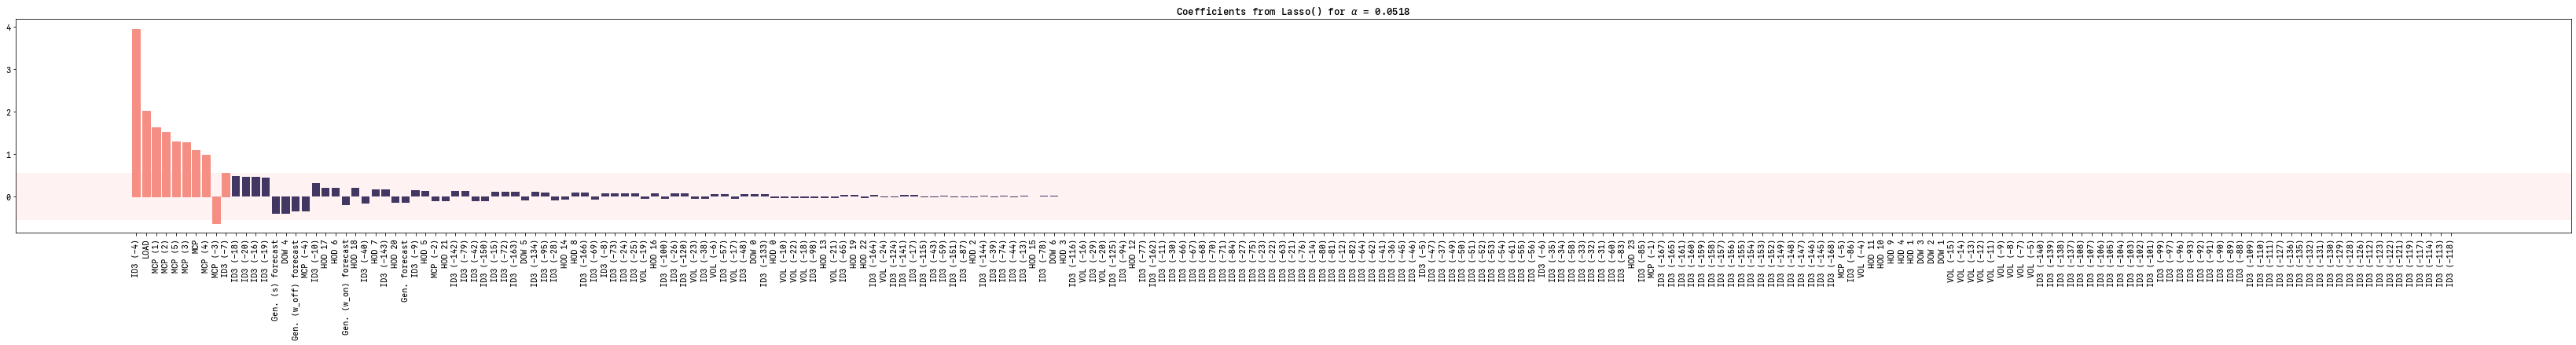

In [20]:
COEFS_sort = COEFS.reindex(COEFS['Coefficients'].abs().sort_values(ascending = False).index)

x = COEFS_sort.index
y = COEFS_sort['Coefficients']

fig, ax = plt.subplots(figsize = (len(x)/4, 5))
q = ax.bar(height = y, x = x, width = 0.8)

plt.xticks(rotation = 90)
ax.set_title(rf'Coefficients from {model_type} for $\alpha$ = {round(alpha, 4)}')

ax.axhspan(threshold, -threshold, facecolor = hex_salmon, alpha = 0.1)

# for t in [threshold, -threshold]:
#     ax.axhline(t, linewidth = 1, linestyle = '-', color = hex_indigo, alpha = 0.5, label = rf'$\alpha$: {round(alpha, 4)}')

for item in q[0:n_features]:
     item.set_color(hex_salmon)

## (Optional) Determine optimal alpha (3)

In [21]:
# import numpy as np

# from sklearn.linear_model import LassoCV
# from yellowbrick.datasets import load_concrete
# from yellowbrick.regressor import AlphaSelection

# hex_salmon = '#F68F83'
# hex_gold = '#BC9661'
# hex_indigo = '#2D2E5F'
# hex_maroon = '#8C4750'
# hex_white = '#FAFAFA'
# hex_blue = '#7EB5D2'

# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib as mpl
# from matplotlib.dates import DateFormatter
# import matplotlib.dates as dates

# import matplotlib.font_manager as font_manager
# mpl.font_manager._rebuild()

# mpl.rcParams['font.family'] = 'SF Mono'
# mpl.rcParams['font.weight'] = 'medium'
# mpl.rcParams['axes.titleweight'] = 'semibold'
# mpl.rcParams['axes.labelweight'] = 'medium'
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[hex_indigo, hex_salmon, hex_maroon])
# mpl.rcParams["figure.titlesize"] = 'large'
# mpl.rcParams["figure.titleweight"] = 'semibold'

# # Load the regression dataset
# X, y = X_train, y_train

# # Create a list of alphas to cross-validate against
# alphas = np.logspace(-5, 0.5, 50)

# # Instantiate the linear model and visualizer
# model = LassoCV(alphas = alphas)
# visualizer = AlphaSelection(model)
# visualizer.fit(X, y)
# visualizer.show();

# Visualise 

In [22]:
# print(), print('Selected columns:'), print()
# print(sel_.get_support())

In [23]:
# print(), print(colored('Summary:', 'blue')), print()

# print(f'Total features: {X_train.shape[1]}')
# print(f'Selected features: {len(X_train.columns[(sel_.get_support())])}')
# print(f'Features with coefficients shrank to zero: {np.sum(sel_.estimator_.coef_ == 0)}')

# print(), print(colored('Selected columns:', 'blue')), print()
# print(X_train.columns[sel_.get_support()])

In [24]:
# coefficients = pd.DataFrame()

# for h in range(0, 24):

#     X = features.drop(labels=['ID3', 'Load forecast'], axis=1)
#     y = features['ID3']

#     X = X.iloc[X.index.hour == h]
#     y = y.iloc[y.index.hour == h]

#     X_train, X_test, y_train, y_test = train_test_split(
#         X,
#         y,
#         test_size = 0.3,
#         random_state = 0,
#         shuffle = True)

#     scaler = StandardScaler()
#     scaler.fit(X_train)

#     lab_enc = LabelEncoder()
#     y_train = lab_enc.fit_transform(y_train)

#     # sel_ = SelectFromModel(Lasso(alpha = 3, random_state = 10))
#     sel_ = SelectFromModel(Ridge(alpha = 1000, random_state = 10))

#     sel_.fit(scaler.transform(X_train), y_train)

#     coefficients[f'H {h}'] = sel_.estimator_.coef_

#     print(), print(colored('Selected columns:', 'blue')), print()
#     print(X_train.columns[sel_.get_support()])

# coefficients = coefficients.set_index([X_train.columns])

In [25]:
# importances = pd.DataFrame()

# for h in range(0, 24):
#     importances[f'H {h}'] = coefficients[f'H {h}'].abs() / coefficients[f'H {h}'].abs().sum()

# importances = importances.set_index([X_train.columns])

In [26]:
# fig, ax = plt.subplots(figsize = (10, 40))
# cbar_ax = fig.add_axes([.95, .75, .05, .10])
# sns.heatmap(ax = ax, data = importances, cmap = "coolwarm", cbar_ax = cbar_ax)

# ax.xaxis.set_ticks_position('top')
# ax.xaxis.set_label_position('top')

# for label in ax.xaxis.get_ticklabels()[::2]:
#     label.set_visible(False)

# ax.set_xlabel('Hourly instrument', labelpad = 10)
# ax.set_ylabel('Feature', labelpad = 10)

# ax.set_title(f'Feature importance', pad = 10);

In [27]:
coefficients = pd.DataFrame()

for h in range(0, 24):

    X = features.drop(labels=['ID3', 'LOAD_F', 'LOAD_FE'], axis=1)
    y = features['ID3']

    X = X.iloc[X.index.hour == h]
    y = y.iloc[y.index.hour == h]

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size = 0.3,
        random_state = 0,
        shuffle = False)

    X_train_unscaled = X_train

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train_unscaled)

    lab_enc = LabelEncoder()
    y_train = lab_enc.fit_transform(y_train)

    sel_ = SelectFromModel(Lasso(alpha=3, random_state=10))
    sel_.fit(X_train, y_train)

    coefficients[f'H {h}'] = sel_.estimator_.coef_

    print(), print(colored('Selected columns:', 'blue')), print()
    print(X_train_unscaled.columns[sel_.get_support()])

coefficients = coefficients.set_index([X_train_unscaled.columns])

ID3 (-19)', 'ID3 (-23)', 'ID3 (-26)', 'ID3 (-28)',
       'ID3 (-32)', 'ID3 (-33)', 'ID3 (-38)', 'ID3 (-42)', 'ID3 (-46)',
       'ID3 (-49)', 'ID3 (-51)', 'ID3 (-54)', 'ID3 (-65)', 'ID3 (-67)',
       'ID3 (-71)', 'ID3 (-76)', 'ID3 (-82)', 'ID3 (-94)', 'ID3 (-97)',
       'ID3 (-98)', 'ID3 (-100)', 'ID3 (-105)', 'ID3 (-106)', 'ID3 (-109)',
       'ID3 (-115)', 'ID3 (-116)', 'ID3 (-119)', 'ID3 (-123)', 'ID3 (-124)',
       'ID3 (-128)', 'ID3 (-132)', 'ID3 (-140)', 'ID3 (-144)', 'ID3 (-147)',
       'ID3 (-148)', 'ID3 (-149)', 'ID3 (-155)', 'ID3 (-158)', 'ID3 (-162)',
       'ID3 (-165)', 'ID3 (-167)', 'MCP (5)', 'MCP (3)', 'MCP (2)', 'MCP (1)',
       'MCP (-1)', 'MCP (-2)', 'MCP (-3)', 'MCP (-5)', 'VOL (-4)', 'VOL (-6)',
       'VOL (-7)', 'VOL (-9)', 'VOL (-11)', 'VOL (-12)', 'VOL (-14)',
       'VOL (-16)', 'VOL (-20)', 'VOL (-21)', 'VOL (-24)', 'Gen. (s) forecast',
       'Gen. (w_on) forecast', 'DOW 0', 'DOW 2', 'DOW 4', 'DOW 5', 'DOW 6'],
      dtype='object')

Selected columns:


In [28]:
importances = pd.DataFrame()

for h in range(0, 24):
    importances[f'H {h}'] = coefficients[f'H {h}'].abs() / coefficients[f'H {h}'].abs().sum()

importances = importances.set_index([X_train_unscaled.columns])

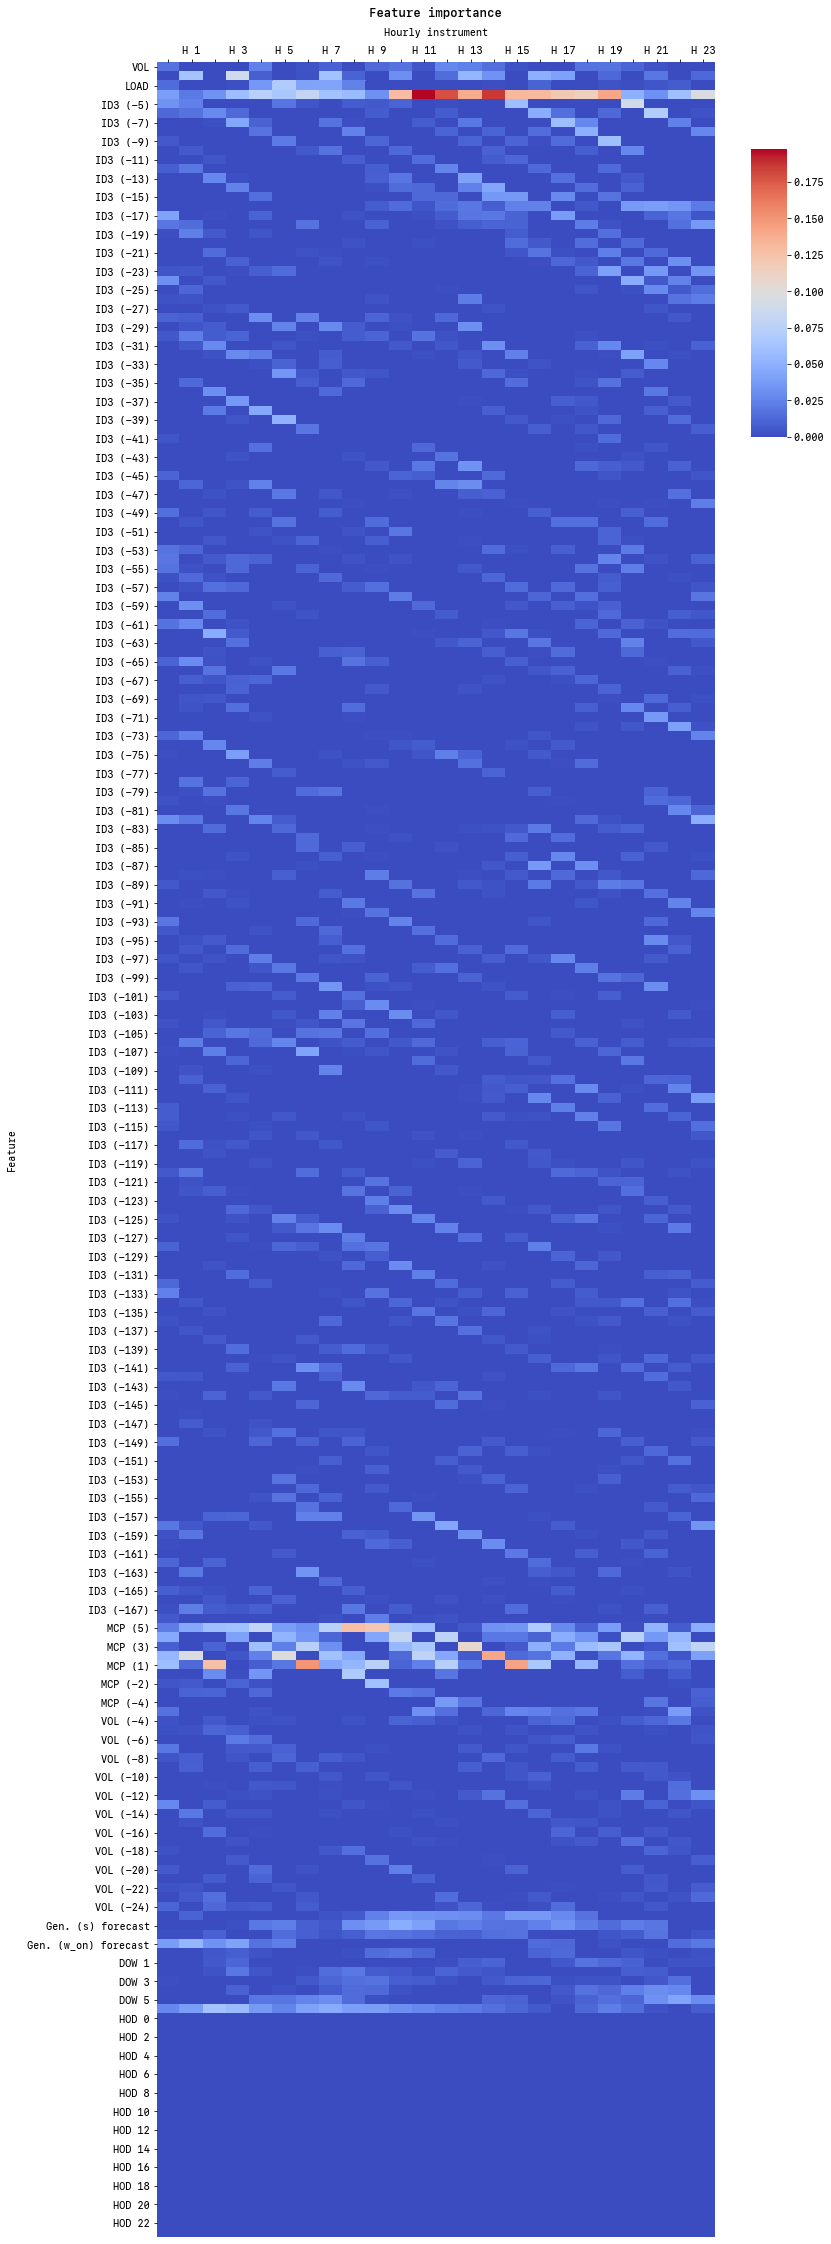

In [29]:
fig, ax = plt.subplots(figsize = (10, 40))
cbar_ax = fig.add_axes([.95, .75, .05, .10])
sns.heatmap(ax = ax, data = importances, cmap = "coolwarm", cbar_ax = cbar_ax)

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax.set_xlabel('Hourly instrument', labelpad = 10)
ax.set_ylabel('Feature', labelpad = 10)

ax.set_title(f'Feature importance', pad = 10);